# Install libraries and download the dataset

In [1]:
!pip install kaggle
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 37 kB/s 
     |████████████████████████████████| 199 kB 52.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=613681a7e54357eb4e817938b4839b48ad8a106b19034303d0d661c169bb9a6e
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk import ngrams
import random
import re
import itertools
from scipy.special import binom

In [3]:
#Create spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

In [4]:
#Connect to Kaggle and download the dataset
os.environ["KAGGLE_USERNAME"] = "itsbi00"
os.environ["KAGGLE_KEY"] = "12a03bebadfce60b1d9484e4967e08ff"

!kaggle datasets download bwandowando/ukraine-russian-crisis-twitter-dataset-1-2-m-rows -f UkraineWar/UkraineWar/0404_UkraineCombinedTweetsDeduped.csv.gzip

 90% 85.0M/94.2M [00:00<00:00, 148MB/s]
100% 94.2M/94.2M [00:00<00:00, 125MB/s]


In [5]:
!unzip "/content/0404_UkraineCombinedTweetsDeduped.csv.gzip.zip"

Archive:  /content/0404_UkraineCombinedTweetsDeduped.csv.gzip.zip
  inflating: 0404_UkraineCombinedTweetsDeduped.csv.gzip  


# Preprocessing

In [6]:
df = pd.read_csv('/content/0404_UkraineCombinedTweetsDeduped.csv.gzip', compression='gzip')
df.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,userid,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetid,tweetcreatedts,retweetcount,text,hashtags,language,coordinates,favorite_count,extractedts
0,0,1135480334,LeonFirer,NaN,NaN,90,6,31,2013-01-30 23:27:36.000000,1510769113542832128,2022-04-04 00:00:00.000000,2846,As the whole world watches in horror the image...,"[{'text': 'Kyiv', 'indices': [73, 78]}, {'text...",en,NaN,0,2022-04-04 00:07:06.155602
1,1,50383631,sofia779933,"ЛЮБЛЮ ЖИЗНЬ, ЮМОР И ВСЕ ПОЗИТИВНОЕ!","Москва, Россия",5000,1220,127329,2009-06-24 18:09:39.000000,1510769114389880844,2022-04-04 00:00:00.000000,342,Exclusive footage of #Bucha after the liberati...,"[{'text': 'Bucha', 'indices': [42, 48]}]",en,NaN,0,2022-04-04 00:07:06.121124
2,2,152930351,AnonGhostt,Secret for Public,UK,7,5033,376522,2010-06-07 07:02:46.000000,1510769114541084674,2022-04-04 00:00:00.000000,358,📢 The #ICC Office of the Prosecutor is investi...,"[{'text': 'ICC', 'indices': [25, 29]}, {'text'...",en,NaN,0,2022-04-04 00:07:06.071706
3,3,1250755269644222464,15minutosUSA,Descubre lo que pasa en tu país y en el mundo ...,"Miami, Florida",523,3876,33616,2020-04-16 11:58:25.000000,1510769114582724608,2022-04-04 00:00:00.000000,0,#Mundo: Conmoción mundial por la masacre de #B...,"[{'text': 'Mundo', 'indices': [0, 6]}, {'text'...",es,NaN,0,2022-04-04 00:07:06.055175
4,4,2288308578,EuromaidanPR,#1 Independent Citizen Media about #Ukraine | ...,Ukraine,3592,87638,76529,2014-01-12 15:28:39.000000,1510769115627204612,2022-04-04 00:00:00.000000,7,As the whole world watches in horror the image...,"[{'text': 'Kyiv', 'indices': [53, 58]}, {'text...",en,NaN,16,2022-04-04 00:07:06.033660


In [7]:
print(df.shape)
print(len(set(df.language)))

(430421, 18)
61


In [8]:
#from https://gist.github.com/n1n9-jp/5857d7725f3b14cbc8ec3e878e4307ce

def remove_emojis(data):
    emoj = re.compile("["
        u"\U00002700-\U000027BF"  # Dingbats
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U00002600-\U000026FF"  # Miscellaneous Symbols
        u"\U0001F300-\U0001F5FF"  # Miscellaneous Symbols And Pictographs
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U0001F680-\U0001F6FF"  # Transport and Map Symbols
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [9]:
def cleaner(text):
  #remove @nickname, hashtags, links, emojis
  text = re.sub("(@[A-Za-z0-9]+)","",text)
  text = re.sub("#","",text)
  text = re.sub(r'http\S+', '', text)
  text = re.sub('\w+:\/\/\S+', '', text)
  text = remove_emojis(text)
  text = text.lower()
  return text

In [10]:
#select a portion of the english speaking tweets only
num_docs = 10000

text = df[df.language == "en"]

#select the textual column, the only one of interest
text = text.text[:num_docs]
text = text.map(lambda x: cleaner(x))
text.head()

0    as the whole world watches in horror the image...
1    exclusive footage of bucha after the liberatio...
2     the icc office of the prosecutor is investiga...
4    as the whole world watches in horror the image...
5    the anonymous collective has sent 7.000.000 an...
Name: text, dtype: object

# Tokenization

In [11]:
#create a function to split into 5-grams
K = 5

def kgram(sentence,k):
  ngr = set(ngrams(sentence, k))
  return ngr

# Min-hashing

### Characteristic matrix

In [12]:
#characteristic matrix column
#if a shingle is present in the tweet, the cell is equal to 1, 0 otherwise
def col_cm(gram, rows):
  col = np.zeros((len(rows),), dtype=int)
  for shingle in gram:
    col[rows.index(shingle)] = 1

  return col

In [13]:
def char_matrix(rdd):

  #trasform tweets into sets of k-grams
  rdd = rdd.map(lambda gram: kgram(gram,K))

  #create the rows of the matrix, i.e. the set of all kgrams
  rows = rdd.flatMap(lambda gram: gram).distinct().collect()

  #create the columns of the characteristic matrix
  columns = rdd.map(lambda gram: col_cm(gram, rows))

  return len(rows),columns

### Signature matrix

In [15]:
#create the sequence of new indexes to reorder the characteristic matrix
def shuffler(len_r, rnd):
  shuffler = np.array([(i + rnd) * rnd % len_r for i in range(len_r)])
  return shuffler

In [16]:
#create a matrix of new sequences: each one works as hash function
def hash_matrix(len_r):
  hash_matrix = []
  rnd_lst = random.sample(range(0, len_r), H)
  for rnd in rnd_lst:
    hash_matrix.append(shuffler(len_r,rnd))
  return hash_matrix

In [17]:
#for every text and every hash function, generate the signature
def hash_column(col,len_r,hash_matrix):
  sig_col = np.full(H,len_r)
  for i in range(len_r):
    if(col[i] == 1):
      for j in range(H):
        if(sig_col[j] > hash_matrix[j][i]):
          sig_col[j] = hash_matrix[j][i]
  return sig_col

In [18]:
#wrap up the signature of each text
def sig_matrix(hash_matrix,len_r,columns):

  columns = columns.map(lambda x : hash_column(x,len_r,hash_matrix))
  return columns

In [19]:
#number of hash functions
global H
H = 100

In [20]:
#Eventually, start the process by parallelizing the tweets
rdd = sc.parallelize(text).cache()

In [21]:
len_r,columns = char_matrix(rdd)
sig_matrix = sig_matrix(hash_matrix(len_r),len_r,columns)

# LSH and final results

In [23]:
#define the number of rows per band
global r
r = 5
global b
b = H/r
b

20.0

#### Choice of the threshold

In [24]:
s = pd.Series([0.01 * x for x in range(100)], name='s')
p = pd.Series([ (1 - (1 - sx**r)**b) for sx in s], name='p')
sdf = pd.merge(s,p, right_index = True, left_index = True)
sdf[::10]

,s,p
0,0.0,0.000000
10,0.1,0.000200
20,0.2,0.006381
30,0.3,0.047494
40,0.4,0.186050
50,0.5,0.470051
60,0.6,0.801902
70,0.7,0.974781
80,0.8,0.999644
90,0.9,1.000000


Text(0.5, 0, 's')

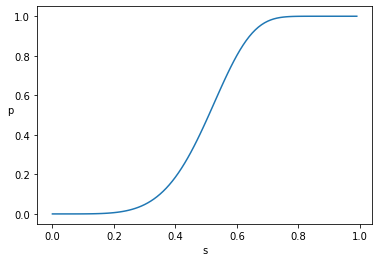

In [25]:
plt.plot(s,p)
plt.ylabel("p", rotation=0)
plt.xlabel("s")

In [26]:
global t
t = round((1/b)**(1/r),2)
t

0.55

#### Comparison

In [27]:
#group by splitting every hashed document into b bands
def hash_array(x):
  return abs(hash(x.tostring())).to_bytes(8,"big").hex()

In [28]:
#Jaccard similarity between two documents
def j_sim(l1,l2,i,j,n_parts):
  jacc = sum([1 for ii, jj in zip(l1, l2) if ii == jj and ii != 0])/n_parts
  if jacc != 0:
    return (i,j)

In [29]:
#the final wrapper takes the lsh-hashed documents and compares them
def results(res):
  global ls_sim
  global jc
  len_res = len(res)
  #list of candidates
  jc = [(j_sim(res[i],res[j],i,j,b)) for i in range(len_res-1) for j in range(i+1,len_res)]
  jc = [i for i in jc if i is not None]

  #get the list of items involved in similarities
  ls_sim = list(itertools.chain(*jc))
  ls_sim = set(ls_sim)

  #the percentage of similar couples is calculated by dividing the number of similar couples by the number of total couples
  sim_perc = len(jc)/binom(num_docs, 2)*100
  sim_perc = round(sim_perc, 3)
  print(f'The percentage of similar items is: {sim_perc}%')

In [30]:
#hash every column to a bucket (an integer) in each band
#takes about 30 minutes
res = sig_matrix.map(lambda x: [hash_array(arr) for arr in (np.array_split(x, b))]).collect()

In [31]:
results(res)

The percentage of similar items is: 0.712%


#### Optional: check similarity of each couple at the k-gram level
IMPORTANT: This section can only be used with smaller datasets

In [32]:
'''def j_sim2(l1,l2,i,j,n_parts):
  jacc = sum([1 for ii, jj in zip(l1, l2) if ii == jj and ii != 0])/(n_parts - sum([1 for ii, jj in zip(l1, l2) if ii == 0 and jj == 0]))
  if jacc >= t:
    return (i,j)'''

In [33]:
'''def final_results(res):
  global jc

  res = [(sub[1], sub[0]) for sub in res]
  res = dict(res)

  jc2 = [(j_sim2(res[jc_tup[0]],res[jc_tup[0]],jc_tup[0],jc_tup[1],len_r)) for jc_tup in jc]

  sim_perc = len(jc2)/binom(num_docs, 2)*100
  sim_perc = round(sim_perc, 3)
  print(f'The percentage of similar items is: {sim_perc}%')'''

In [22]:
#create indexes
'''res1 = columns.zipWithIndex()'''

In [39]:
'''res1 = res1.filter(lambda x : x[1] in ls_sim).collect()

In [ ]:
'''final_results(res1)